Imports

In [155]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits

Open and Display Photo

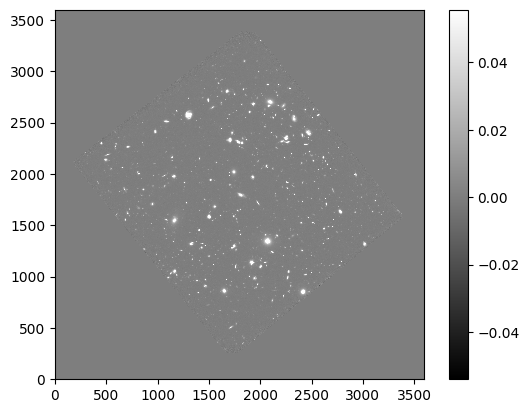

In [156]:
filename = './hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits' #Establishing filepath
#fits.info(filename)
data = fits.getdata(filename, ext=0) #getting data from HDU 0 of the file
data = data.byteswap().newbyteorder()
m, s = np.mean(data), np.std(data) #getting mean and standard deviation
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower') #showing image
plt.savefig('hubble.png')
plt.colorbar();

0.0
0.0005398219218477607


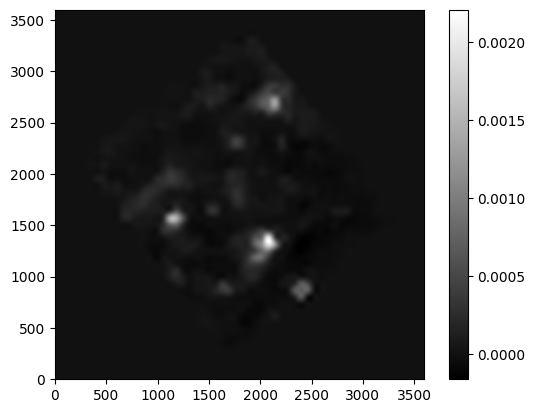

In [157]:
bkg = sep.Background(data) #grabbing background

print(bkg.globalback) #printing background average
print(bkg.globalrms) #printing background  

bimage = bkg.back()
plt.imshow(bimage, interpolation='nearest', cmap='gray', origin='lower') #Displaying background
plt.colorbar();
plt.savefig('hubbleBg.png')


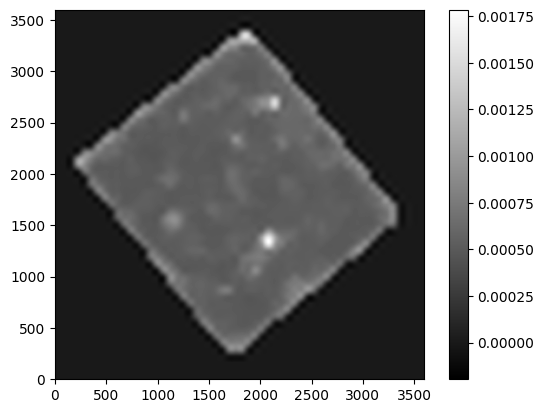

In [158]:
plt.imshow(bkg.rms(), interpolation='nearest', cmap='gray', origin='lower') #displaying background RMS
plt.colorbar();
plt.savefig('hubbleBgRMS.png')
nobk = data - bkg #subtracting background from data

Object Detection

Number of objects found: 8639


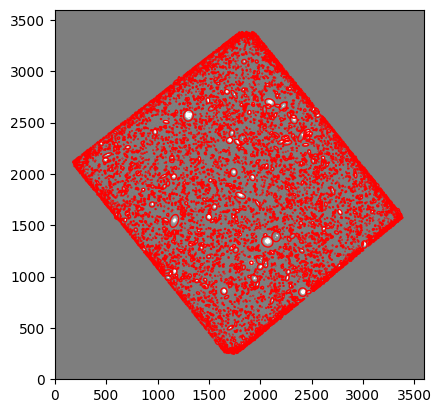

In [174]:
objects = sep.extract(nobk, 1.5, err=bkg.globalrms) #finding objects in no-background data
fig, ax = plt.subplots()
m, s = np.mean(nobk), np.std(nobk)
im = ax.imshow(nobk, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)): #for each object, plot a ellipse on top of it corresponding to the dimensions and orientation of the object
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('hubbleObjects.png')
print("Number of objects found: {:d}".format(len(objects))) 

Reading Fluxes

In [160]:
#reading fluxes of found objects
flux, fluxerr, flag = sep.sum_circle(nobk, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i])) #print the first the fluxes and error of the first 10 objects

for i in range(len(objects)):
    if flux[i] > 0.1:
        print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i])) #print the first the fluxes and error of the first 10 objects


object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
object 10: flux = 0.104682 +/- 0.323559
object 99: flux = 0.139415 +/- 0.373395
object 126: flux = 1.151943 +/- 1.073290
object 127: flux = 0.148642 +/- 0.385552
object 128: flux = 0.138287 +/- 0.371880
object 155: flux = 0.109363 +/- 0.330713
object 192: flux = 0.544781 +/- 0.738098
object 195: flux = 1.130115 +/- 1.063073
object 219: flux = 0.111580 +/- 0.334048
object 222: flux = 0.107808 +/- 0.328354
object 223: flux = 0.677386 +/- 0.823040
object 224: flux = 0.111987 +/- 0.334657
object 235: flux = 0.236873 +/- 0.486705
object 236: flux = 0.153025 +/- 0.391194
object 243: flux = 0.125305 +/- 0.3

Histogramming Fluxes

Text(0, 0.5, 'Object Count')

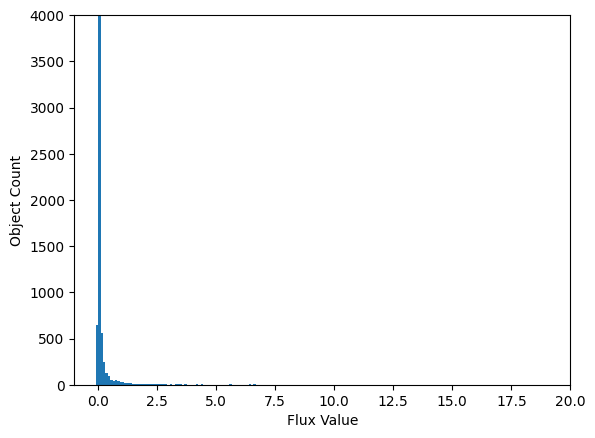

In [173]:
b = 100 #number of bins
plt.hist(flux, bins = 1000, range = (-1,100))
plt.xlim(-1,20)
plt.ylim(0,4000)
plt.xlabel("Flux Value")
plt.ylabel("Object Count")

Flux Statistics

In [162]:
print("Mean: {:f}\nMedian: {:f}\nStandard Deviation: {:f}".format(np.mean(flux), np.median(flux), np.std(flux)))

Mean: 0.361369
Median: 0.030926
Standard Deviation: 9.237125


Largest Outlier

The largest outlier is object 2064 with a flux of 807.297284 +/- 28.412978, shown here:


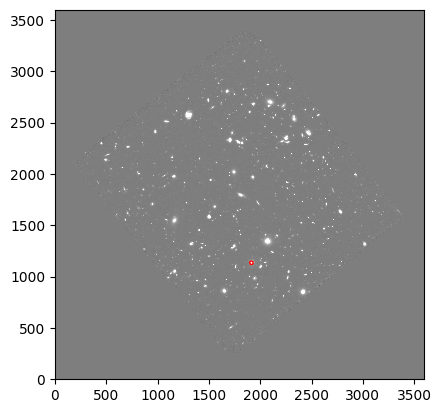

In [163]:
max = 0
for i in range(len(objects)):
    if flux[i] > flux[max]:
        max = i
print("The largest outlier is object {:d} with a flux of {:f} +/- {:f}, shown here:".format(max, flux[max], fluxerr[max]))

fig, ax = plt.subplots()
m, s = np.mean(nobk), np.std(nobk)
im = ax.imshow(nobk, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

e = Ellipse(xy=(objects['x'][max], objects['y'][max]),
            width=6*objects['a'][max],
            height=6*objects['b'][max],
            angle=objects['theta'][max] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)

Rescale Function

In [164]:
def rescaleIm(data):
    pdatatmp = data.copy()
    m = np.nanmean(pdatatmp)
    vplmin = m/2.0
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.0)
    pdatatmp[pdatatmp<vplmin] = vplmin
    pdatatmp = np.log10(pdatatmp)
    return pdatatmp, vpmin, vpmax

Color Compiled Image

3600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


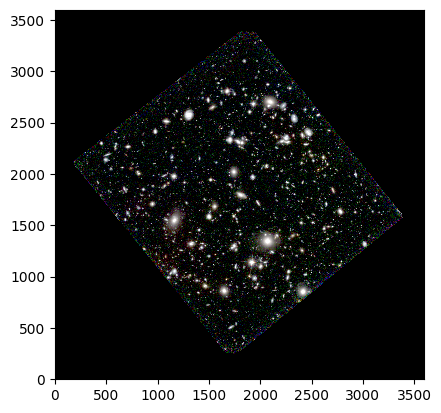

In [165]:
import matplotlib.colors as colors
print(len(data))
false_rgb = np.zeros((3600,3600,3))

data1 = fits.getdata('./hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits', ext=0)
data2 = fits.getdata('./hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits', ext=0)

data_res, dmin, dmax = rescaleIm(data)
data_res1, dmin1, dmax1 = rescaleIm(data1)
data_res2, dmin2, dmax2 = rescaleIm(data2)

data_res[data_res<dmin] = dmin
data_res[data_res>dmax] = dmax
data_res1[data_res1<dmin1] = dmin1
data_res1[data_res1>dmax1] = dmax1
data_res2[data_res2<dmin2] = dmin2
data_res2[data_res2>dmax2] = dmax2

false_rgb[:,:,0] = (data_res2-dmin2)/(dmax2-dmin2)
false_rgb[:,:,1] = (data_res1-dmin1)/(dmax1-dmin1)
false_rgb[:,:,2] = (data_res-dmin)/(dmax-dmin)
plt.imshow(false_rgb, interpolation='nearest', origin='lower')
plt.savefig('HubbleFalseRGB.png')
